In [130]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy.io import fits
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
import copy
import random
import math

In [2]:
def read_unequal_table(txt_file, num_columns=383, filler=''):
    """Read table from file."""
    table = []
    with open(txt_file) as file:
        for row in file:
            values = row.split()
            if len(values) > num_columns:
                raise ValueError('Number of values more than num_columns')
            elif len(values) < num_columns:
                diff = num_columns - len(values)
                padding = [filler]*diff
                values = values + padding
            else:
                pass
            table.append(values)
    return np.array(table)

In [3]:
def read_norm_spectra(txt_file):
    """Read the saved set of normalized spectra"""
    alldata = read_unequal_table(txt_file)
    srcids = alldata[:, 0].astype(str)
    normed_spectra = alldata[:, 1:-2].astype(float)
    netcounts = alldata[:, -2].astype(float)
    src_class = alldata[:, -1].astype(str)
    return srcids, normed_spectra, netcounts, src_class

In [4]:
def refine_labels(label_array):
    """Refine labels to 4 classes."""
    refined_labels = np.full(len(label_array), '', dtype='<U16')
    for i, label in enumerate(label_array):
        if label == '':
            continue
        if label == 'AGN' or label == 'CV':
            refined_labels[i] = label
        elif label == 'LM-STAR' or label == 'HM-STAR' or label == 'YSO':
            refined_labels[i] = 'STAR'
        else:
            refined_labels[i] = 'NS/BH'
    return refined_labels

In [5]:
pn_srcids, pn_normspec, pn_counts, pn_class = read_norm_spectra('../Data/Brightpn_id_normspec_counts_label.txt')

In [6]:
pn_class_refined = refine_labels(pn_class)

In [7]:
np.unique(pn_class_refined)

array(['', 'AGN', 'CV', 'NS/BH', 'STAR'], dtype='<U16')

In [8]:
def check_spectra(normspec, refinedclass):
    """Check the normalized spectra of different classes."""
    en_bins = np.linspace(0.5, 10, len(normspec[0]))
    classes_unique = np.unique(refinedclass)
    plt.figure(figsize=(20, 12))
    plt.xlabel('Energy [keV]')
    plt.ylabel('Normalized counts [/bin]')
    plt.xscale('log')
    plt.xlim(0.5, 10.0)
    for classes in classes_unique:
        if classes != '':
            plt.plot(en_bins,
                     np.mean(normspec[refinedclass == classes], axis=0), label=classes)
    plt.legend()
    plt.show

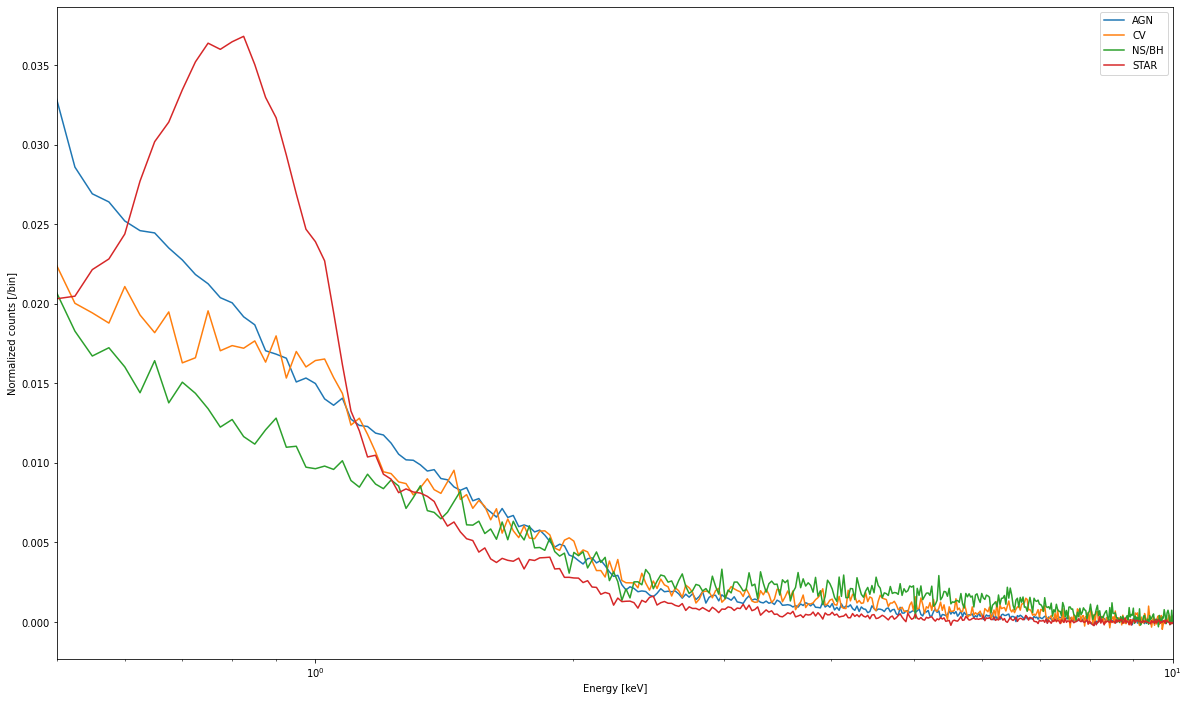

In [9]:
check_spectra(pn_normspec, pn_class_refined)

In [10]:
print(f"Number of AGN: {len(np.where(pn_class_refined == 'AGN')[0])}")
print(f"Number of STAR: {len(np.where(pn_class_refined == 'STAR')[0])}")
print(f"Number of NS: {len(np.where(pn_class_refined == 'NS/BH')[0])}")
print(f"Number of CVs: {len(np.where(pn_class_refined == 'CV')[0])}")

Number of AGN: 1339
Number of STAR: 1193
Number of NS: 99
Number of CVs: 99


## Baseline model for stars and AGN

In [11]:
labelled_args = np.where(np.logical_or(pn_class_refined == 'STAR',
                                       pn_class_refined == 'AGN'))
print(len(labelled_args[0]))

2532


In [12]:
unlabelled_args = np.where(pn_class_refined == '')
print(len(unlabelled_args[0]))

57876


In [13]:
print(len(labelled_args[0])+len(unlabelled_args[0]))

60408


In [14]:
pn_normspec_labelled = pn_normspec[labelled_args]
pn_spec_labels = np.zeros(len(labelled_args[0]), dtype=int)
for i, label in enumerate(pn_class_refined[labelled_args]):
    if label == 'STAR':
        pn_spec_labels[i] = 1

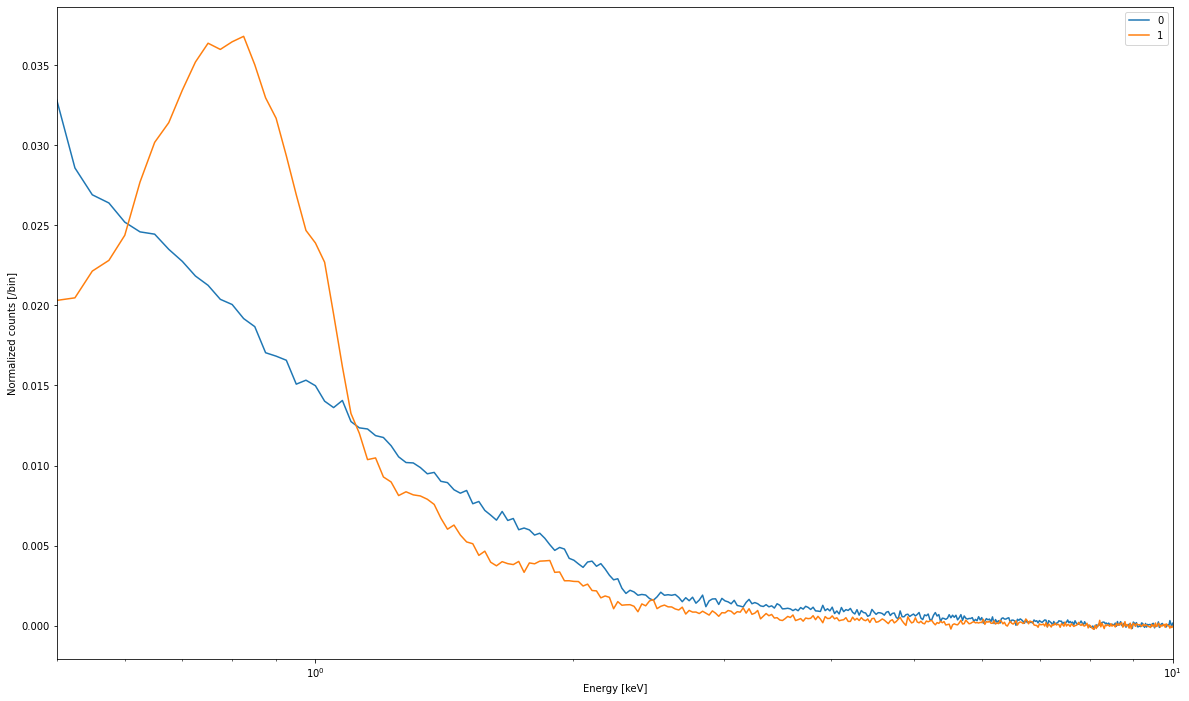

In [15]:
check_spectra(pn_normspec_labelled, pn_spec_labels)

In [20]:
def get_tensor_datasets(labelled_normspec, labels, unlabelled_normspecs):
    """Get tensor datasets"""
    unlabelled_dataset = TensorDataset(torch.tensor(
        unlabelled_normspecs, dtype=torch.float32).unsqueeze(1))
    label_spectra_tensor = torch.tensor(labelled_normspec,
                                        dtype=torch.float32).unsqueeze(1)
    class_tensor = torch.tensor(labels, dtype=torch.long)
    labelled_dataset = TensorDataset(label_spectra_tensor, class_tensor)
    
    #Train-test split
    train_idx, test_idx = train_test_split(np.arange(len(labels)),
                                           test_size=0.2,
                                           stratify=labels,
                                           random_state=32)

    train_ds = Subset(labelled_dataset, train_idx)
    test_ds = Subset(labelled_dataset, test_idx)
    return unlabelled_dataset, train_ds, test_ds

In [21]:
unlabelled_specdata, train_data, test_data = get_tensor_datasets(
    pn_normspec_labelled, pn_spec_labels, pn_normspec[unlabelled_args])

In [344]:



class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=11, padding=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(2)  # 380 → 190
        self.drop1 = nn.Dropout(dropout_rate)  # <-- dropout after first conv block

        self.conv2 = nn.Conv1d(8, 16, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(2)  # 190 → 95
        self.drop2 = nn.Dropout(dropout_rate)  # <-- dropout after second conv block

        # final feature size = 16 * 95 = 1520
        self.fc1 = nn.Linear(16 * 95, 64)
        self.drop3 = nn.Dropout(dropout_rate)  # <-- dropout before final layer
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop3(x)
        return self.fc2(x)

    
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.2):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=11, padding=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(2)  # 380 → 190
        self.drop1 = nn.Dropout(dropout_rate)  # <-- dropout after first conv block

        self.conv2 = nn.Conv1d(8, 16, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(2)  # 190 → 95
        self.drop2 = nn.Dropout(dropout_rate)  # <-- dropout after second conv block
        
        self.conv3 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(2)  # 95 → 47
        self.drop3 = nn.Dropout(dropout_rate)  # <-- dropout after second conv block

        # final feature size = 16 * 95 = 1520
        self.fc1 = nn.Linear(32 * 47, 512)
        self.drop4 = nn.Dropout(dropout_rate)  # <-- dropout before final layer
        self.fc2 = nn.Linear(512, 128)
        self.drop5 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 64)
        self.drop6 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop4(x)
        x = torch.relu(self.fc2(x))
        x = self.drop5(x)
        x = torch.relu(self.fc3(x))
        x = self.drop6(x)
        return self.fc4(x)

    
class OverfitNet1D(nn.Module):
    """
    Very large 1D CNN → large FC network intended to overfit small datasets.
    Remove dropout / strong regularization to encourage memorization.
    """
    def __init__(self, in_channels=1, num_classes=2, dropout_rate=0.0):
        super().__init__()
        # Deep conv tower (many channels)
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, 128, kernel_size=15, padding=7),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=15, padding=7),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),

            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=11, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),

            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(512, 1024, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(1024, 1024, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)   # collapse temporal dimension
        )
        # Huge fully-connected head
        self.fc = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            # intentionally NO dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # x: (batch, channels, length)
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # (batch, 1024)
        x = self.fc(x)
        return x


def l1_penalty(model):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_norm


def make_model(model_type=SimpleCNN, numclass=2, drop_rate=0.0):
    return model_type(num_classes=numclass, dropout_rate=drop_rate)

In [321]:
make_model(ComplexCNN, 2, 0.0)

ComplexCNN(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.0, inplace=False)
  (conv3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=1504, out_features=512, bias=True)
  (drop4): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (drop5): Dropout(p=0.0, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (drop6): Dropout(p=0.0, inplace=False)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
make_model(SimpleCNN, 2, 0.2)

SimpleCNN(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1520, out_features=64, bias=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [380]:
# -----------------------
# 2. Training function
# -----------------------
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


def get_batch_loss(model, inputs_l, labels_l, model_opt, loss_cr,
                   inputs_ul=None, pseudo_labels_ul=None, mask=None,
                   l1_lam=0.0, lam_u=0.0, soft_labels=None):
    """Train one batch of the model. Pseudolabel option available.

    Assuming the inputs and labels have already been cast onto device
    If you want to use soft labels, pass prob_ul instead of pseudo_labsl
    """
    outputs_l = model(inputs_l)
    loss_l = loss_cr(outputs_l, labels_l) # Supervised loss

    # For accuracy
    pred_l = torch.max(outputs_l, 1)[1]
    total_l = labels_l.size(0)
    correct_l = (pred_l == labels_l).sum().item()
    
    if inputs_ul is not None and mask is not None and mask.sum() > 0:
        outputs_ul = model(inputs_ul[mask])
        # Get unsupervised accuracy
        pred_ul = torch.max(outputs_ul, 1)[1]
        total_ul = mask.sum()
        correct_ul = (pred_ul == pseudo_labels_ul[mask]).sum().item()
        batch_ul_acc = correct_ul/total_ul
        
        # Get unsupervised loss
        if lam_u > 0:
            if soft_labels is not None:
                # Soft labels
                loss_ul = nn.functional.kl_div(
                    nn.functional.log_softmax(outputs_ul, dim=1),
                    soft_labels[mask], reduction='batchmean')
            else:
                loss_ul = loss_cr(outputs_ul, pseudo_labels_ul[mask])
        else:
            loss_ul = 0
    else:
        batch_ul_acc = None
        loss_ul = 0
    
    if l1_lam > 0:
        l1_loss = l1_lam*l1_penalty(model) # L1 reg.
    else:
        l1_loss = 0
    
    batch_loss = loss_l + lam_u*loss_ul + l1_loss
    # print(f'Supervised Loss:{loss_l} | Unsupervised Loss:{loss_ul} | Batch loss: {batch_loss}')
    
    return batch_loss, correct_l/total_l, batch_ul_acc


def train_one_batch(model, prev_batch_loss, inputs_l, labels_l, model_opt, 
                    loss_cr, inputs_ul=None, l1_lam=0.0, lam_u=0.0,
                    thresh=0.95, use_softlabels=False):
    """Train model by one epoch.
    
    Batch loss from the previous batch, not the current batch.
    """
    # First get pseudo labels from the model before updating the weights
    pseudolabels_ul, probs_ul, mask = None, None, None
    if inputs_ul is not None:
        with torch.no_grad():
            probs_ul = torch.softmax(model(inputs_ul), dim=1)
            conf_ul, pseudolabels_ul = torch.max(probs_ul, dim=1)
            mask = (conf_ul > thresh)
            soft_labels = probs_ul if use_softlabels else None

    else:
        soft_labels = None
    
    
    if prev_batch_loss is not None:
        # If previous batch loss is None, don't update anything and
        # don't calculate unsupervised loss, else
        # Update model weights
        model_opt.zero_grad()
        prev_batch_loss.backward()
        model_opt.step()
        # clear memory
        del prev_batch_loss
        torch.cuda.empty_cache()
    else:
        inputs_ul = None
    
    # Calculate batch loss accuracy for current batch using pseudolabels before
    # updating the weights
    
    # Get accuracy and loss for current batch based on labels before update
    
    batch_loss, batch_l_acc, batch_ul_acc = get_batch_loss(
        model, inputs_l, labels_l, model_opt, loss_cr,
        inputs_ul, pseudolabels_ul, mask, l1_lam, lam_u, soft_labels)
    
    return batch_loss, batch_l_acc, batch_ul_acc



def train_one_epoch(model, l_loader, model_optimizer, loss_criterion, device,
                    ul_loader=None, l1_lambda=0.0, lambda_u=0.0,
                    threshold=0.95, prev_loss=None,
                    update_last_model=None):
    """Train one epoch of the ML model

    If prev_loss is given, it's assumed that the model hasn't been updated yet
    """
    model.train()
    total_loss, runacc_l, runacc_ul = 0.0, 0.0, 0.0  # , 0.0
    num_labeled_batches = len(l_loader)
    num_unlabeled_batches = len(ul_loader) if ul_loader is not None else 0

    # Making lists for random access if needed
    labeled_batches = list(l_loader)
    unlabeled_batches = list(ul_loader) if ul_loader is not None else []
    if ul_loader is not None:
        random.shuffle(unlabeled_batches)
    
    used_unlabeled = 0
    num_ulbatches = 0

    for numbatch, (inputs_l, labels_l) in enumerate(l_loader):
        inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)
        # Fetch unlabeled data
        if ul_loader is not None:
            if used_unlabeled < num_unlabeled_batches:
                ul_batch = unlabeled_batches[used_unlabeled]
                if isinstance(ul_batch, (tuple, list)):
                    inputs_ul = ul_batch[0].to(device)
                else:
                    inputs_ul = ul_batch.to(device)
                used_unlabeled += 1
            else:
                ul_batch = random.choice(unlabeled_batches)
                if isinstance(ul_batch, (tuple, list)):
                    inputs_ul = ul_batch[0].to(device)
                else:
                    inputs_ul = ul_batch.to(device)
        else:
            inputs_ul=None

        if prev_loss is not None:
            # If the loss and model are from previous step i.e. weights not yet
            # updated
            batch_loss, batch_acc_l, batch_acc_u = train_one_batch(
                model, prev_loss, inputs_l, labels_l, model_optimizer,
                loss_criterion, inputs_ul=inputs_ul, l1_lam=l1_lambda,
                lam_u=lambda_u, thresh=threshold)
            del prev_loss
            torch.cuda.empty_cache()
        else:
            # If prev loss not given and model weights are already updated,
            # e.g. in the first batch of first epoch, calculate supervised loss
            # only
            print('No prev loss')
            batch_loss, batch_acc_l, batch_acc_u = train_one_batch(
                model, prev_loss,
                inputs_l, labels_l, model_optimizer, loss_criterion,
                inputs_ul=None)
            
        prev_loss = batch_loss

        total_loss += batch_loss.item()
        runacc_l = (runacc_l*numbatch + batch_acc_l)/(numbatch + 1)
        if batch_acc_u is not None:
            runacc_ul = (
                runacc_ul*num_ulbatches + batch_acc_u)/(num_ulbatches + 1)
            num_ulbatches += 1

    # If unlabelled data remain
    while used_unlabeled < num_unlabeled_batches:
        ul_batch = unlabeled_batches[used_unlabeled]
        if isinstance(ul_batch, (tuple, list)):
            inputs_ul = ul_batch[0].to(device)
        else:
            inputs_ul = ul_batch.to(device)
        used_unlabeled += 1
        inputs_l, labels_l = random.choice(labeled_batches)
        inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)

        # It's assumed that the weights haven't been updated
        batch_loss, batch_acc_l, batch_acc_u = train_one_batch(
                model, prev_loss, inputs_l, labels_l, model_optimizer,
                loss_criterion, inputs_ul=inputs_ul, l1_lam=l1_lambda,
                lam_u=lambda_u, thresh=threshold)
        del prev_loss
        torch.cuda.empty_cache()
        prev_loss = batch_loss

        numbatch += 1
        total_loss += batch_loss.item()
        runacc_l = (runacc_l*numbatch + batch_acc_l)/(numbatch + 1)
        if batch_acc_u is not None:
            runacc_ul = (
                runacc_ul*num_ulbatches + batch_acc_u)/(num_ulbatches + 1)
            num_ulbatches += 1
    
    # acc_l = evaluate(model, loader, device)
    avg_loss = total_loss/(numbatch+1)
    if update_last_model:
        model_optimizer.zero_grad()
        prev_loss.backward()
        model_optimizer.step()
    return model, avg_loss, runacc_l, runacc_ul, prev_loss


def train_model(base_model, full_train_dataset, test_dataset,
                unlabeled_dataset=None, epochs=20, batch_size=32,
                unlabeled_batch_size=64, k_folds=5, l1_lambda=0.0,
                l2_lambda=1.0e-4, droprate=0.2, numclasses=2, threshold=0.95,
                model_class=None, base_model_is_fn=True, op_alg='Adam',
                verbose=1, lambda_u_func=None):
    """Train model. If unlabeled data is provider use Lee (2013)"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)
    if model_class is None and base_model_is_fn:
        model_class = SimpleCNN

    val_acc_per_fold = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(
                                        kfold.split(full_train_dataset)):
        print(f"\n--- Fold {fold+1}/{k_folds} ---")
        train_subset = torch.utils.data.Subset(full_train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_train_dataset, val_idx)

        # Load Datasets
        train_loader = DataLoader(train_subset, batch_size=batch_size,
                                  shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size,
                                shuffle=False)
        if unlabeled_dataset is not None:
            unlabeled_loader = DataLoader(
                unlabeled_dataset, batch_size=unlabeled_batch_size,
                shuffle=True)
        else:
            unlabeled_loader=None

        # Set up model, optimizer and loss
        if base_model_is_fn:
            model = base_model(model_class, numclasses, droprate).to(device)
        else:
            model = copy.deepcopy(base_model)
        if op_alg == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=1e-3,
                                   weight_decay=l2_lambda)
        elif op_alg == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9,
                                  weight_decay=l2_lambda, nesterov=True)
        criterion = nn.CrossEntropyLoss()
        prev_epochloss = None
        update_last_model = False
        
        for epoch in range(epochs):
            if epoch == epochs - 1:
                update_last_model = True
            if lambda_u_func is None:
                if epoch < 2:
                    lambda_u = 0
                else:
                    lambda_u = min(3.0, 0.2 + 3*(epoch - 1) / (epochs*0.8))
    
            else:
                lambda_u = lambda_u_func(epoch, epochs)

            threshold_new = min(threshold,
                                (0.70 - (0.70-threshold)*epoch/(epochs*0.5)))
            (model, avg_loss, acc_train_l, acc_train_ul,
             epoch_loss) = train_one_epoch(
                model, train_loader, optimizer, criterion, device,
                ul_loader=unlabeled_loader, l1_lambda=l1_lambda,
                lambda_u=lambda_u, threshold=threshold,
                prev_loss=prev_epochloss, update_last_model=update_last_model)
            val_acc = evaluate(model, val_loader, device)
            prev_epochloss = epoch_loss
            if verbose == 1:
                print(
                    f"Epoch {epoch+1}/{epochs} | Loss={avg_loss:.4f} | "
                    f"Labeled Train Acc={acc_train_l:.4f} | "
                    f"Val Acc={val_acc:.4f} | "
                    f"Unlabeled Train Acc={acc_train_ul:.4f} | "
                    f"lambda_u:{lambda_u:.4f} | "
                    f"Threshold:{threshold_new}")

        models.append(model)
        val_acc_per_fold.append(val_acc)

    print(f"\nCross-validation results: {val_acc_per_fold}")
    print(f"Mean Val Acc: {np.mean(val_acc_per_fold):.4f} ± {np.std(val_acc_per_fold):.4f}")

    # Pick the best fold’s model
    best_model = models[np.argmax(val_acc_per_fold)]


    # Final test evaluation
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_acc = evaluate(best_model, test_loader, device)
    print(f"\nHold-out Test Accuracy: {test_acc:.4f}")

    return best_model
# -----------------------
# 3. Pseudo-labeling function
# -----------------------
def get_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    pseudo_X, pseudo_y = [], []
    with torch.no_grad():
        for xb in unlabeled_loader:
            xb = xb[0].to(device)  # DataLoader yields a tuple
            probs = torch.softmax(model(xb), dim=1)
            conf, pred = torch.max(probs, dim=1)
            mask = conf > threshold
            pseudo_X.append(xb[mask].cpu())
            pseudo_y.append(pred[mask].cpu())
    if len(pseudo_X) == 0:
        return None
    pseudo_X = torch.cat(pseudo_X)
    pseudo_y = torch.cat(pseudo_y)
    return TensorDataset(pseudo_X, pseudo_y)



In [352]:
conf_ul2.min()

tensor(0.5001)

# Supervised training bounds

In [311]:
# No regularization
simplecnn_noreg = train_model(make_model, train_data, test_data, l2_lambda=0.0, l1_lambda=0.0, droprate=0.0, verbose=1,
                              model_class=SimpleCNN)


--- Fold 1/5 ---
No prev loss
Epoch 1/20 | Loss=0.3958 | Labeled Train Acc=0.8473 | Val Acc=0.5728 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 2/20 | Loss=0.2018 | Labeled Train Acc=0.9319 | Val Acc=0.8494 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 3/20 | Loss=0.1384 | Labeled Train Acc=0.9582 | Val Acc=0.8667 | Unlabeled Train Acc=0.0000 | lambda_u:0.1625 | Threshold:0.95
Epoch 4/20 | Loss=0.1133 | Labeled Train Acc=0.9638 | Val Acc=0.8988 | Unlabeled Train Acc=0.0000 | lambda_u:0.2250 | Threshold:0.95
Epoch 5/20 | Loss=0.0795 | Labeled Train Acc=0.9776 | Val Acc=0.9037 | Unlabeled Train Acc=0.0000 | lambda_u:0.2875 | Threshold:0.95
Epoch 6/20 | Loss=0.0574 | Labeled Train Acc=0.9849 | Val Acc=0.8938 | Unlabeled Train Acc=0.0000 | lambda_u:0.3500 | Threshold:0.95
Epoch 7/20 | Loss=0.0533 | Labeled Train Acc=0.9843 | Val Acc=0.8914 | Unlabeled Train Acc=0.0000 | lambda_u:0.4125 | Threshold:0.95
Epoch 8/20 | Loss=0.0344 | Labeled Tra

Epoch 2/20 | Loss=0.2395 | Labeled Train Acc=0.9174 | Val Acc=0.9235 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 3/20 | Loss=0.1597 | Labeled Train Acc=0.9449 | Val Acc=0.9407 | Unlabeled Train Acc=0.0000 | lambda_u:0.1625 | Threshold:0.95
Epoch 4/20 | Loss=0.1226 | Labeled Train Acc=0.9620 | Val Acc=0.9457 | Unlabeled Train Acc=0.0000 | lambda_u:0.2250 | Threshold:0.95
Epoch 5/20 | Loss=0.0996 | Labeled Train Acc=0.9700 | Val Acc=0.9457 | Unlabeled Train Acc=0.0000 | lambda_u:0.2875 | Threshold:0.95
Epoch 6/20 | Loss=0.0800 | Labeled Train Acc=0.9756 | Val Acc=0.9284 | Unlabeled Train Acc=0.0000 | lambda_u:0.3500 | Threshold:0.95
Epoch 7/20 | Loss=0.0604 | Labeled Train Acc=0.9843 | Val Acc=0.9481 | Unlabeled Train Acc=0.0000 | lambda_u:0.4125 | Threshold:0.95
Epoch 8/20 | Loss=0.0457 | Labeled Train Acc=0.9898 | Val Acc=0.9457 | Unlabeled Train Acc=0.0000 | lambda_u:0.4750 | Threshold:0.95
Epoch 9/20 | Loss=0.0340 | Labeled Train Acc=0.9939 | Val Acc=0.9506 

In [312]:
# Add regularization
simplecnn_withreg = train_model(make_model, train_data, test_data, l2_lambda=1.0e-4, l1_lambda=1.0e-5, droprate=0.2, verbose=0,
                             model_class=SimpleCNN)


--- Fold 1/5 ---
No prev loss

--- Fold 2/5 ---
No prev loss

--- Fold 3/5 ---
No prev loss

--- Fold 4/5 ---
No prev loss

--- Fold 5/5 ---
No prev loss

Cross-validation results: [0.9407407407407408, 0.9481481481481482, 0.9185185185185185, 0.945679012345679, 0.9432098765432099]
Mean Val Acc: 0.9393 ± 0.0107

Hold-out Test Accuracy: 0.9349


In [345]:
# No regularization
overfitcnn_noreg = train_model(make_model, train_data, test_data, l2_lambda=0.0, l1_lambda=0.0, droprate=0.0, verbose=1,
                               model_class=OverfitNet1D)


--- Fold 1/5 ---
No prev loss
Epoch 1/20 | Loss=0.6964 | Labeled Train Acc=0.5183 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 2/20 | Loss=0.6919 | Labeled Train Acc=0.5327 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 3/20 | Loss=0.6917 | Labeled Train Acc=0.5320 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.1625 | Threshold:0.95
Epoch 4/20 | Loss=0.6919 | Labeled Train Acc=0.5331 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.2250 | Threshold:0.95
Epoch 5/20 | Loss=0.6917 | Labeled Train Acc=0.5342 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.2875 | Threshold:0.95
Epoch 6/20 | Loss=0.6915 | Labeled Train Acc=0.5316 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.3500 | Threshold:0.95
Epoch 7/20 | Loss=0.6915 | Labeled Train Acc=0.5338 | Val Acc=0.5111 | Unlabeled Train Acc=0.0000 | lambda_u:0.4125 | Threshold:0.95
Epoch 8/20 | Loss=0.6916 | Labeled Tra

KeyboardInterrupt: 

In [315]:
cnn3FC_withreg = train_model(make_model, train_data, test_data, l2_lambda=1.0e-4, l1_lambda=1.0e-5, droprate=0.1, verbose=1,
                           model_class=CNN_3FC)


--- Fold 1/5 ---
No prev loss
Epoch 1/20 | Loss=0.5150 | Labeled Train Acc=0.8130 | Val Acc=0.5457 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 2/20 | Loss=0.2855 | Labeled Train Acc=0.9062 | Val Acc=0.8914 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 3/20 | Loss=0.2174 | Labeled Train Acc=0.9402 | Val Acc=0.9259 | Unlabeled Train Acc=0.0000 | lambda_u:0.1625 | Threshold:0.95
Epoch 4/20 | Loss=0.1809 | Labeled Train Acc=0.9515 | Val Acc=0.9012 | Unlabeled Train Acc=0.0000 | lambda_u:0.2250 | Threshold:0.95
Epoch 5/20 | Loss=0.1696 | Labeled Train Acc=0.9555 | Val Acc=0.9111 | Unlabeled Train Acc=0.0000 | lambda_u:0.2875 | Threshold:0.95
Epoch 6/20 | Loss=0.1413 | Labeled Train Acc=0.9675 | Val Acc=0.8963 | Unlabeled Train Acc=0.0000 | lambda_u:0.3500 | Threshold:0.95
Epoch 7/20 | Loss=0.1666 | Labeled Train Acc=0.9528 | Val Acc=0.8840 | Unlabeled Train Acc=0.0000 | lambda_u:0.4125 | Threshold:0.95
Epoch 8/20 | Loss=0.1241 | Labeled Tra

Epoch 2/20 | Loss=0.3118 | Labeled Train Acc=0.8895 | Val Acc=0.9136 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.95
Epoch 3/20 | Loss=0.2449 | Labeled Train Acc=0.9207 | Val Acc=0.9235 | Unlabeled Train Acc=0.0000 | lambda_u:0.1625 | Threshold:0.95
Epoch 4/20 | Loss=0.2094 | Labeled Train Acc=0.9423 | Val Acc=0.9259 | Unlabeled Train Acc=0.0000 | lambda_u:0.2250 | Threshold:0.95
Epoch 5/20 | Loss=0.1803 | Labeled Train Acc=0.9490 | Val Acc=0.8938 | Unlabeled Train Acc=0.0000 | lambda_u:0.2875 | Threshold:0.95
Epoch 6/20 | Loss=0.1654 | Labeled Train Acc=0.9561 | Val Acc=0.9259 | Unlabeled Train Acc=0.0000 | lambda_u:0.3500 | Threshold:0.95
Epoch 7/20 | Loss=0.1518 | Labeled Train Acc=0.9589 | Val Acc=0.9086 | Unlabeled Train Acc=0.0000 | lambda_u:0.4125 | Threshold:0.95
Epoch 8/20 | Loss=0.1525 | Labeled Train Acc=0.9623 | Val Acc=0.8642 | Unlabeled Train Acc=0.0000 | lambda_u:0.4750 | Threshold:0.95
Epoch 9/20 | Loss=0.1303 | Labeled Train Acc=0.9718 | Val Acc=0.8741 

In [375]:
# Second way to train model
test_model = make_model()

test_model = train_model(test_model, train_data, test_data, l2_lambda=0.0, l1_lambda=0.0, droprate=0.0,
                         base_model_is_fn=False)


--- Fold 1/5 ---
No prev loss
Epoch 1/20 | Loss=0.3718 | Labeled Train Acc=0.8388 | Val Acc=0.5605 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.7
Epoch 2/20 | Loss=0.1758 | Labeled Train Acc=0.9406 | Val Acc=0.9210 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.725
Epoch 3/20 | Loss=0.1186 | Labeled Train Acc=0.9577 | Val Acc=0.9235 | Unlabeled Train Acc=0.0000 | lambda_u:0.3875 | Threshold:0.75
Epoch 4/20 | Loss=0.0934 | Labeled Train Acc=0.9702 | Val Acc=0.9012 | Unlabeled Train Acc=0.0000 | lambda_u:0.5750 | Threshold:0.7749999999999999
Epoch 5/20 | Loss=0.0578 | Labeled Train Acc=0.9874 | Val Acc=0.8741 | Unlabeled Train Acc=0.0000 | lambda_u:0.7625 | Threshold:0.7999999999999999
Epoch 6/20 | Loss=0.0440 | Labeled Train Acc=0.9920 | Val Acc=0.9358 | Unlabeled Train Acc=0.0000 | lambda_u:0.9500 | Threshold:0.825
Epoch 7/20 | Loss=0.0311 | Labeled Train Acc=0.9945 | Val Acc=0.9407 | Unlabeled Train Acc=0.0000 | lambda_u:1.1375 | Threshold:0.85
Epoch 8/2

Epoch 1/20 | Loss=0.3724 | Labeled Train Acc=0.8531 | Val Acc=0.6346 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.7
Epoch 2/20 | Loss=0.1817 | Labeled Train Acc=0.9368 | Val Acc=0.9333 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.725
Epoch 3/20 | Loss=0.1185 | Labeled Train Acc=0.9600 | Val Acc=0.9309 | Unlabeled Train Acc=0.0000 | lambda_u:0.3875 | Threshold:0.75
Epoch 4/20 | Loss=0.0867 | Labeled Train Acc=0.9749 | Val Acc=0.9432 | Unlabeled Train Acc=0.0000 | lambda_u:0.5750 | Threshold:0.7749999999999999
Epoch 5/20 | Loss=0.0663 | Labeled Train Acc=0.9849 | Val Acc=0.9284 | Unlabeled Train Acc=0.0000 | lambda_u:0.7625 | Threshold:0.7999999999999999
Epoch 6/20 | Loss=0.0517 | Labeled Train Acc=0.9859 | Val Acc=0.9210 | Unlabeled Train Acc=0.0000 | lambda_u:0.9500 | Threshold:0.825
Epoch 7/20 | Loss=0.0345 | Labeled Train Acc=0.9917 | Val Acc=0.9284 | Unlabeled Train Acc=0.0000 | lambda_u:1.1375 | Threshold:0.85
Epoch 8/20 | Loss=0.0240 | Labeled Train

In [134]:
# No regularization
model_noreg = train_model(make_model, train_data, test_data, l2_lambda=0.0, l1_lambda=0.0, droprate=0.5, verbose=0)


--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

Cross-validation results: [0.9234567901234568, 0.9185185185185185, 0.9209876543209876, 0.9259259259259259, 0.9333333333333333]
Mean Val Acc: 0.9244 ± 0.0051

Hold-out Test Accuracy: 0.8994


In [59]:
# Adding dropouts
for drop in [0.1, 0.2, 0.3, 0.4]:
    for l1 in [0.0, 1.0e-6, 1.0e-5, 1.0e-4]:
        for l2 in [1.0e-5, 5.0e-5, 1.0e-4, 2.0e-4]:
            print(f"Droprate:{drop}, L1_lambda:{l1},L2_lambda:{l2}")
            bestmodel = train_model(make_model, train_data, test_data,
                                    l2_lambda=l2, l1_lambda=l1, droprate=drop,
                                    k_folds=10, verbose=0)

Droprate:0.1, L1_lambda:0.0,L2_lambda:1e-05

--- Fold 1/10 ---

--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9211822660098522, 0.9211822660098522, 0.916256157635468, 0.9211822660098522, 0.9310344827586207, 0.9504950495049505, 0.9108910891089109, 0.9653465346534653, 0.9405940594059405, 0.8910891089108911]
Mean Val Acc: 0.9269 ± 0.0200

Hold-out Test Accuracy: 0.9231
Droprate:0.1, L1_lambda:0.0,L2_lambda:5e-05

--- Fold 1/10 ---

--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9359605911330049, 0.9261083743842364, 0.9556650246305419, 0.9310344827586207, 0.9359605911330049, 0.9207920792079208, 0.9356435643564357, 0.9207920792079208, 0.9455445544554455, 0.9356435643564357]
Mean Val Acc:


--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9458128078817734, 0.9359605911330049, 0.9261083743842364, 0.9310344827586207, 0.9310344827586207, 0.8811881188118812, 0.9158415841584159, 0.9455445544554455, 0.9207920792079208, 0.9306930693069307]
Mean Val Acc: 0.9264 ± 0.0176

Hold-out Test Accuracy: 0.9290
Droprate:0.2, L1_lambda:0.0,L2_lambda:5e-05

--- Fold 1/10 ---

--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9211822660098522, 0.9113300492610837, 0.9014778325123153, 0.9655172413793104, 0.916256157635468, 0.9158415841584159, 0.9851485148514851, 0.9504950495049505, 0.9356435643564357, 0.9207920792079208]
Mean Val Acc: 0.9324 ± 0.0253

Hold-out Test Accuracy: 0.9349
Droprate:0.2, 


--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9507389162561576, 0.8472906403940886, 0.9261083743842364, 0.9507389162561576, 0.916256157635468, 0.9603960396039604, 0.9306930693069307, 0.9504950495049505, 0.9207920792079208, 0.9702970297029703]
Mean Val Acc: 0.9324 ± 0.0330

Hold-out Test Accuracy: 0.9389
Droprate:0.3, L1_lambda:0.0,L2_lambda:5e-05

--- Fold 1/10 ---

--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9064039408866995, 0.9605911330049262, 0.9458128078817734, 0.9310344827586207, 0.9408866995073891, 0.9306930693069307, 0.9108910891089109, 0.9653465346534653, 0.9554455445544554, 0.9405940594059405]
Mean Val Acc: 0.9388 ± 0.0186

Hold-out Test Accuracy: 0.9369
Droprate:0.3, 


--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9211822660098522, 0.916256157635468, 0.9408866995073891, 0.9113300492610837, 0.9310344827586207, 0.9504950495049505, 0.9455445544554455, 0.9257425742574258, 0.9158415841584159, 0.9405940594059405]
Mean Val Acc: 0.9299 ± 0.0131

Hold-out Test Accuracy: 0.9191
Droprate:0.4, L1_lambda:0.0,L2_lambda:5e-05

--- Fold 1/10 ---

--- Fold 2/10 ---

--- Fold 3/10 ---

--- Fold 4/10 ---

--- Fold 5/10 ---

--- Fold 6/10 ---

--- Fold 7/10 ---

--- Fold 8/10 ---

--- Fold 9/10 ---

--- Fold 10/10 ---

Cross-validation results: [0.9014778325123153, 0.9261083743842364, 0.9310344827586207, 0.9064039408866995, 0.8817733990147784, 0.8811881188118812, 0.9752475247524752, 0.8910891089108911, 0.9405940594059405, 0.9801980198019802]
Mean Val Acc: 0.9215 ± 0.0340

Hold-out Test Accuracy: 0.9231
Droprate:0.4, 

In [84]:
# Some regularization
model_reg = train_model(make_model, train_data, test_data, l2_lambda=1.0e-4, l1_lambda=1.0e-5, droprate=0.2, verbose=1)


--- Fold 1/5 ---
Epoch 1/20 | Loss=0.4836 | Labeled Train Acc=0.7890 | Val Acc=0.5432 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000
Epoch 2/20 | Loss=0.3065 | Labeled Train Acc=0.8847 | Val Acc=0.8741 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000
Epoch 3/20 | Loss=0.2502 | Labeled Train Acc=0.9099 | Val Acc=0.8914 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000
Epoch 4/20 | Loss=0.2312 | Labeled Train Acc=0.9224 | Val Acc=0.9062 | Unlabeled Train Acc=0.0000 | lambda_u:0.1000
Epoch 5/20 | Loss=0.1927 | Labeled Train Acc=0.9352 | Val Acc=0.8889 | Unlabeled Train Acc=0.0000 | lambda_u:0.2000
Epoch 6/20 | Loss=0.1869 | Labeled Train Acc=0.9286 | Val Acc=0.9111 | Unlabeled Train Acc=0.0000 | lambda_u:0.3000
Epoch 7/20 | Loss=0.1627 | Labeled Train Acc=0.9393 | Val Acc=0.8716 | Unlabeled Train Acc=0.0000 | lambda_u:0.4000
Epoch 8/20 | Loss=0.1491 | Labeled Train Acc=0.9491 | Val Acc=0.8765 | Unlabeled Train Acc=0.0000 | lambda_u:0.5000
Epoch 9/20 | Loss=0.1484 | Labeled Train Acc=0.9565 | 

Epoch 11/20 | Loss=0.1870 | Labeled Train Acc=0.9380 | Val Acc=0.8840 | Unlabeled Train Acc=0.0000 | lambda_u:0.8000
Epoch 12/20 | Loss=0.1831 | Labeled Train Acc=0.9371 | Val Acc=0.9481 | Unlabeled Train Acc=0.0000 | lambda_u:0.9000
Epoch 13/20 | Loss=0.1395 | Labeled Train Acc=0.9531 | Val Acc=0.9358 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 14/20 | Loss=0.1359 | Labeled Train Acc=0.9577 | Val Acc=0.9506 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 15/20 | Loss=0.1429 | Labeled Train Acc=0.9540 | Val Acc=0.9556 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 16/20 | Loss=0.1323 | Labeled Train Acc=0.9570 | Val Acc=0.9407 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 17/20 | Loss=0.1368 | Labeled Train Acc=0.9500 | Val Acc=0.9481 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 18/20 | Loss=0.1254 | Labeled Train Acc=0.9604 | Val Acc=0.9407 | Unlabeled Train Acc=0.0000 | lambda_u:1.0000
Epoch 19/20 | Loss=0.1217 | Labeled Train Acc=0.9627 | Val Acc=0

## Pseudo-label Training

### Lee (2013)

In [144]:
unlabelled_specdata_subset = Subset(unlabelled_specdata, np.arange(20000))

In [376]:
train_model(make_model, train_data, test_data, l2_lambda=0.0, l1_lambda=0.0, droprate=0.0,
                         base_model_is_fn=True)


--- Fold 1/5 ---
No prev loss
Epoch 1/20 | Loss=0.4310 | Labeled Train Acc=0.7917 | Val Acc=0.5506 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.7
Epoch 2/20 | Loss=0.2645 | Labeled Train Acc=0.8941 | Val Acc=0.9210 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.725
Epoch 3/20 | Loss=0.1602 | Labeled Train Acc=0.9461 | Val Acc=0.8593 | Unlabeled Train Acc=0.0000 | lambda_u:0.3875 | Threshold:0.75
Epoch 4/20 | Loss=0.1331 | Labeled Train Acc=0.9533 | Val Acc=0.9062 | Unlabeled Train Acc=0.0000 | lambda_u:0.5750 | Threshold:0.7749999999999999
Epoch 5/20 | Loss=0.0916 | Labeled Train Acc=0.9730 | Val Acc=0.9259 | Unlabeled Train Acc=0.0000 | lambda_u:0.7625 | Threshold:0.7999999999999999
Epoch 6/20 | Loss=0.0747 | Labeled Train Acc=0.9792 | Val Acc=0.9210 | Unlabeled Train Acc=0.0000 | lambda_u:0.9500 | Threshold:0.825
Epoch 7/20 | Loss=0.0578 | Labeled Train Acc=0.9843 | Val Acc=0.9358 | Unlabeled Train Acc=0.0000 | lambda_u:1.1375 | Threshold:0.85
Epoch 8/2

Epoch 1/20 | Loss=0.4472 | Labeled Train Acc=0.8218 | Val Acc=0.5136 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.7
Epoch 2/20 | Loss=0.2090 | Labeled Train Acc=0.9230 | Val Acc=0.8543 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.725
Epoch 3/20 | Loss=0.1305 | Labeled Train Acc=0.9620 | Val Acc=0.8074 | Unlabeled Train Acc=0.0000 | lambda_u:0.3875 | Threshold:0.75
Epoch 4/20 | Loss=0.0989 | Labeled Train Acc=0.9688 | Val Acc=0.8864 | Unlabeled Train Acc=0.0000 | lambda_u:0.5750 | Threshold:0.7749999999999999
Epoch 5/20 | Loss=0.0779 | Labeled Train Acc=0.9770 | Val Acc=0.9407 | Unlabeled Train Acc=0.0000 | lambda_u:0.7625 | Threshold:0.7999999999999999
Epoch 6/20 | Loss=0.0425 | Labeled Train Acc=0.9908 | Val Acc=0.9309 | Unlabeled Train Acc=0.0000 | lambda_u:0.9500 | Threshold:0.825
Epoch 7/20 | Loss=0.0300 | Labeled Train Acc=0.9957 | Val Acc=0.9210 | Unlabeled Train Acc=0.0000 | lambda_u:1.1375 | Threshold:0.85
Epoch 8/20 | Loss=0.0239 | Labeled Train

SimpleCNN(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=1520, out_features=64, bias=True)
  (drop3): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [378]:
train_model(make_model, train_data, test_data, None,
            epochs=20, batch_size=32,
                               unlabeled_batch_size=512, l1_lambda=0.0,
                               l2_lambda=0.0, droprate=0.0,
                               base_model_is_fn=True, k_folds=3, threshold=0.5)


--- Fold 1/3 ---
No prev loss
Epoch 1/20 | Loss=0.3677 | Labeled Train Acc=0.8537 | Val Acc=0.6993 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.5
Epoch 2/20 | Loss=0.2246 | Labeled Train Acc=0.9113 | Val Acc=0.9185 | Unlabeled Train Acc=0.0000 | lambda_u:0.0000 | Threshold:0.5
Epoch 3/20 | Loss=0.1329 | Labeled Train Acc=0.9477 | Val Acc=0.8578 | Unlabeled Train Acc=0.0000 | lambda_u:0.3875 | Threshold:0.5
Epoch 4/20 | Loss=0.0933 | Labeled Train Acc=0.9753 | Val Acc=0.8874 | Unlabeled Train Acc=0.0000 | lambda_u:0.5750 | Threshold:0.5
Epoch 5/20 | Loss=0.0808 | Labeled Train Acc=0.9717 | Val Acc=0.9022 | Unlabeled Train Acc=0.0000 | lambda_u:0.7625 | Threshold:0.5
Epoch 6/20 | Loss=0.0471 | Labeled Train Acc=0.9884 | Val Acc=0.9422 | Unlabeled Train Acc=0.0000 | lambda_u:0.9500 | Threshold:0.5
Epoch 7/20 | Loss=0.0474 | Labeled Train Acc=0.9869 | Val Acc=0.9244 | Unlabeled Train Acc=0.0000 | lambda_u:1.1375 | Threshold:0.5
Epoch 8/20 | Loss=0.0299 | Labeled Train Acc=

SimpleCNN(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=1520, out_features=64, bias=True)
  (drop3): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
lee2013_noregmodel = train_model(make_model, train_data, test_data,
                               unlabelled_specdata, epochs=50, batch_size=32,
                               unlabeled_batch_size=512, l1_lambda=0.0,
                               l2_lambda=0.0, droprate=0.0,
                               base_model_is_fn=True, k_folds=3, threshold=0.5)


--- Fold 1/3 ---
No prev loss
Epoch 1/50 | Loss=0.2592 | Labeled Train Acc=0.8960 | Val Acc=0.9393 | Unlabeled Train Acc=0.9617 | lambda_u:0.0000 | Threshold:0.5
Epoch 2/50 | Loss=0.0936 | Labeled Train Acc=0.9723 | Val Acc=0.9348 | Unlabeled Train Acc=0.9758 | lambda_u:0.0000 | Threshold:0.5
Epoch 3/50 | Loss=0.0653 | Labeled Train Acc=0.9910 | Val Acc=0.9319 | Unlabeled Train Acc=0.9924 | lambda_u:0.2750 | Threshold:0.5
Epoch 4/50 | Loss=0.0398 | Labeled Train Acc=0.9975 | Val Acc=0.9333 | Unlabeled Train Acc=0.9950 | lambda_u:0.3500 | Threshold:0.5
Epoch 5/50 | Loss=0.0287 | Labeled Train Acc=0.9978 | Val Acc=0.9407 | Unlabeled Train Acc=0.9956 | lambda_u:0.4250 | Threshold:0.5
Epoch 6/50 | Loss=0.0233 | Labeled Train Acc=0.9992 | Val Acc=0.9378 | Unlabeled Train Acc=0.9971 | lambda_u:0.5000 | Threshold:0.5
Epoch 7/50 | Loss=0.0195 | Labeled Train Acc=0.9997 | Val Acc=0.9319 | Unlabeled Train Acc=0.9977 | lambda_u:0.5750 | Threshold:0.5
Epoch 8/50 | Loss=0.0165 | Labeled Train Acc=

Epoch 11/50 | Loss=0.0269 | Labeled Train Acc=0.9981 | Val Acc=0.9378 | Unlabeled Train Acc=0.9950 | lambda_u:0.8750 | Threshold:0.5
Epoch 12/50 | Loss=0.0185 | Labeled Train Acc=1.0000 | Val Acc=0.9378 | Unlabeled Train Acc=0.9977 | lambda_u:0.9500 | Threshold:0.5
Epoch 13/50 | Loss=0.0173 | Labeled Train Acc=0.9997 | Val Acc=0.9422 | Unlabeled Train Acc=0.9983 | lambda_u:1.0250 | Threshold:0.5
Epoch 14/50 | Loss=0.0193 | Labeled Train Acc=0.9995 | Val Acc=0.9422 | Unlabeled Train Acc=0.9965 | lambda_u:1.1000 | Threshold:0.5
Epoch 15/50 | Loss=0.0196 | Labeled Train Acc=0.9995 | Val Acc=0.9259 | Unlabeled Train Acc=0.9967 | lambda_u:1.1750 | Threshold:0.5
Epoch 16/50 | Loss=0.0180 | Labeled Train Acc=0.9995 | Val Acc=0.9319 | Unlabeled Train Acc=0.9974 | lambda_u:1.2500 | Threshold:0.5
Epoch 17/50 | Loss=0.0164 | Labeled Train Acc=1.0000 | Val Acc=0.9348 | Unlabeled Train Acc=0.9980 | lambda_u:1.3250 | Threshold:0.5
Epoch 18/50 | Loss=0.0379 | Labeled Train Acc=0.9986 | Val Acc=0.9333

In [379]:
lee2013_regmodel = train_model(make_model, train_data, test_data,
                               unlabelled_specdata, epochs=20,
                               unlabeled_batch_size=512, l1_lambda=1.0e-5,
                               l2_lambda=1.0e-4, droprate=0.2,
                               base_model_is_fn=True, k_folds=5, threshold=0.50)


--- Fold 1/5 ---
No prev loss


UnboundLocalError: local variable 'l1_loss' referenced before assignment

In [131]:
def lambda_linear(epoch, epochs, max_lambda=0.4, warmup_frac=0.4):
    warm = max(1, int(warmup_frac * epochs))
    return max_lambda * min(1.0, epoch / warm)


def lambda_sigmoid(epoch, epochs, max_lambda=0.4):
    x = (epoch / epochs - 0.5) * 8.0   # 8 controls steepness
    return max_lambda * (1.0 / (1.0 + math.exp(-x)))


def lambda_cosine(epoch, epochs, max_lambda=0.4, warmup_frac=0.4):
    warm = max(1, int(warmup_frac * epochs))
    if epoch < warm:
        return max_lambda * 0.5 * (1 - math.cos(math.pi * epoch / warm))
    return max_lambda


In [129]:
@torch.no_grad()
def update_teacher(student, teacher, alpha=0.999):
    for t_params, s_params in zip(teacher.parameters(), student.parameters()):
        t_params.data.mul_(alpha).add_(s_params.data * (1 - alpha))


def train_one_batch_MT(student, teacher, inputs_l, labels_l,
                       model_opt, loss_cr, inputs_ul=None,
                       lam_u=0.0, alpha=0.999, thresh=None):
    """Train one batch for Mean Teacher model."""
    student.train()
    teacher.eval()
    model_opt.zero_grad()

    # --- Supervised loss ---
    outputs_l = student(inputs_l)
    loss_l = loss_cr(outputs_l, labels_l)
    total_loss = loss_l

    # --- Unsupervised consistency loss ---
    if inputs_ul is not None and lam_u > 0:
        with torch.no_grad():
            teacher_probs = torch.softmax(teacher(inputs_ul), dim=1)
        
        student_logits = student(inputs_ul)
        student_log_probs = torch.log_softmax(student_logits, dim=1)

        # Consistency loss: KL(student || teacher)
        loss_cons = nn.functional.kl_div(student_log_probs, teacher_probs,
                                         reduction='batchmean')

        total_loss += lam_u * loss_cons

    # --- Backprop & update ---
    total_loss.backward()
    model_opt.step()
    update_teacher(student, teacher, alpha)

    # Accuracy on labeled data
    pred_l = outputs_l.argmax(dim=1)
    acc_l = (pred_l == labels_l).float().mean().item()

    return total_loss.item(), acc_l


def train_one_epoch_MT(student, teacher, l_loader, model_optimizer,
                       loss_criterion, device, ul_loader=None,
                       lambda_u=0.0, ema_alpha=0.999):
    student.train()
    teacher.eval()

    total_loss, runacc_l = 0.0, 0.0
    num_batches = len(l_loader)
    unlabeled_iter = iter(ul_loader) if ul_loader is not None else None

    for numbatch, (inputs_l, labels_l) in enumerate(l_loader):
        inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)
        inputs_ul = None
        if unlabeled_iter is not None:
            try:
                inputs_ul = next(unlabeled_iter)[0].to(device)
            except StopIteration:
                unlabeled_iter = iter(ul_loader)
                inputs_ul = next(unlabeled_iter)[0].to(device)

        batch_loss, acc_l = train_one_batch_MT(
            student, teacher, inputs_l, labels_l, model_optimizer,
            loss_criterion, inputs_ul=inputs_ul, lam_u=lambda_u, alpha=ema_alpha)

        total_loss += batch_loss
        runacc_l = (runacc_l * numbatch + acc_l) / (numbatch + 1)

    avg_loss = total_loss / (numbatch + 1)
    return student, teacher, avg_loss, runacc_l


def train_model_MT(base_model_fn, full_train_dataset, test_dataset,
                   unlabeled_dataset=None, epochs=20, batch_size=32,
                   unlabeled_batch_size=64, k_folds=3,
                   l2_lambda=1e-4, droprate=0.2, numclasses=2,
                   ema_alpha=0.999, lambda_u_func=None, max_lambda=0.5):
    """Mean Teacher model training."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)
    val_acc_per_fold, models = [], []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(full_train_dataset)):
        print(f"\n--- Fold {fold+1}/{k_folds} ---")
        train_subset = torch.utils.data.Subset(full_train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        unlabeled_loader = (DataLoader(unlabeled_dataset, batch_size=unlabeled_batch_size, shuffle=True)
                            if unlabeled_dataset is not None else None)

        student = base_model_fn(SimpleCNN, numclasses, droprate).to(device)
        teacher = copy.deepcopy(student).to(device)

        optimizer = optim.Adam(student.parameters(), lr=5e-4, weight_decay=l2_lambda)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            lambda_u = lambda_u_func(epoch, epochs, max_lambda=max_lambda) if lambda_u_func else max_lambda
            student, teacher, loss, acc_train = train_one_epoch_MT(
                student, teacher, train_loader, optimizer, criterion,
                device, ul_loader=unlabeled_loader, lambda_u=lambda_u,
                ema_alpha=ema_alpha)
            val_acc = evaluate(student, val_loader, device)
            print(f"Epoch {epoch+1}/{epochs} | Loss={loss:.4f} | Train Acc={acc_train:.4f} | "
                  f"Val Acc={val_acc:.4f} | λ_u={lambda_u:.3f}")
        val_acc_per_fold.append(val_acc)
        models.append(copy.deepcopy(teacher))

    print(f"\nCV Mean Acc: {np.mean(val_acc_per_fold):.4f} ± {np.std(val_acc_per_fold):.4f}")
    best_model = models[np.argmax(val_acc_per_fold)]
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_acc = evaluate(best_model, test_loader, device)
    print(f"\nHold-out Test Accuracy: {test_acc:.4f}")
    return best_model

In [133]:
best_model_test = train_model_MT(
    make_model, train_data, test_data,
    unlabeled_dataset=unlabelled_specdata_subset,
    epochs=20, batch_size=64, unlabeled_batch_size=128,
    ema_alpha=0.999,
    lambda_u_func=lambda_linear,  # from earlier message
    max_lambda=0.4
)


--- Fold 1/3 ---
Epoch 1/20 | Loss=0.5584 | Train Acc=0.7552 | Val Acc=0.5111 | λ_u=0.000
Epoch 2/20 | Loss=0.4231 | Train Acc=0.8440 | Val Acc=0.5185 | λ_u=0.050
Epoch 3/20 | Loss=0.3634 | Train Acc=0.8731 | Val Acc=0.8770 | λ_u=0.100
Epoch 4/20 | Loss=0.3730 | Train Acc=0.8703 | Val Acc=0.9111 | λ_u=0.150
Epoch 5/20 | Loss=0.3510 | Train Acc=0.8838 | Val Acc=0.9067 | λ_u=0.200
Epoch 6/20 | Loss=0.3599 | Train Acc=0.9091 | Val Acc=0.9007 | λ_u=0.250
Epoch 7/20 | Loss=0.3611 | Train Acc=0.9084 | Val Acc=0.9348 | λ_u=0.300
Epoch 8/20 | Loss=0.3717 | Train Acc=0.9261 | Val Acc=0.9052 | λ_u=0.350
Epoch 9/20 | Loss=0.3804 | Train Acc=0.9018 | Val Acc=0.9348 | λ_u=0.400
Epoch 10/20 | Loss=0.3706 | Train Acc=0.9347 | Val Acc=0.9452 | λ_u=0.400
Epoch 11/20 | Loss=0.3542 | Train Acc=0.9297 | Val Acc=0.9319 | λ_u=0.400
Epoch 12/20 | Loss=0.3565 | Train Acc=0.9354 | Val Acc=0.9407 | λ_u=0.400
Epoch 13/20 | Loss=0.3523 | Train Acc=0.9496 | Val Acc=0.9437 | λ_u=0.400
Epoch 14/20 | Loss=0.3458 | T